In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self, in_channel=784, latent_dim=32):
        super(VAE, self).__init__()

        self.in_channel = in_channel
        self.latent_dim = latent_dim
        print('VAE Inputs Channel: ', self.in_channel)
        print('VAE Latent Dims: ', self.latent_dim)

        self.fc1 = nn.Linear(self.in_channel, 256)
        self.fc_mu = nn.Linear(256, self.latent_dim)
        self.fc_logVar = nn.Linear(256, self.latent_dim)

        self.fc2 = nn.Linear(latent_dim, 256)
        self.fc3 = nn.Linear(256, in_channel)

    def encode(self, x):
        #print(x.shape)
        h = F.relu(self.fc1(x))
        mu, log_var = self.fc_mu(h), self.fc_logVar(h)

        return mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var) # 生成var取log->log(σ^2)->2*logσ 乘0.5取exp->得到σ 
        sample = torch.rand_like(std)
        #print(sample)

        return mu + sample*std

    def decode(self, sample):
        out = F.relu(self.fc2(sample))
        return F.sigmoid(self.fc3(out))

    def forward(self, x):
        mu, log_var = self.encode(x)
        sample = self.sampling(mu, log_var)
        out = self.decode(sample)

        return out, mu, log_var




In [ ]:
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

class Network():
    def __init__(self, latent_dims=64, num_epochs=15, batch_size=64, learning_rate=1.0e-3, gpu=True):
        self.latent_dims = latent_dims
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.in_channel = 784 # 784 -> 256 -> latent_dims
        self.learning_rate = learning_rate
        self.gpu = gpu

        self._init_dataset()
        self._init_model()

        
    def _init_dataset(self):

        self.train_data = MNIST(root='./dataset', download=True, train=True, transform=transforms.ToTensor())
        self.test_data = MNIST(root='./dataset', download=True, train=False, transform=transforms.ToTensor())

        self.train_data2 = FashionMNIST(root='./dataset', download=True, train=True, transform=transforms.ToTensor())
        self.test_data2 = FashionMNIST(root='./dataset', download=True, train=False, transform=transforms.ToTensor())

        self.train_queue = data.DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)
        self.test_queue = data.DataLoader(self.test_data, batch_size=self.batch_size, shuffle=True)

        self.train_queue2 = data.DataLoader(self.train_data2, batch_size=self.batch_size, shuffle=True)
        self.test_queue2 = data.DataLoader(self.test_data2, batch_size=self.batch_size, shuffle=True)

    def _init_model(self):
        self.device = torch.device('cuda' if (torch.cuda.is_available() & self.gpu) else 'cpu')

        model = VAE(self.in_channel, self.latent_dims)
        self.model = model.to(self.device)

        self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=self.learning_rate, weight_decay=1e-5)

    def show_images(self, images, num_images=16):
        #sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
        sqrtn = int(np.ceil(np.sqrt(num_images)))

        for index, image in enumerate(images):
            if index < num_images:
                plt.subplot(sqrtn, sqrtn, index+1)
                plt.imshow(image.reshape(28, 28))
                plt.axis('off')

    def plot_reconstructed(self, decoder, r0=(0, 70), r1=(0, 70), number=20):
        plt.figure(figsize=(40, 40))
        w = 28
        img = np.zeros((number*w, number*w))
        for i, y in enumerate(np.linspace(*r1, number)):
            for j, x in enumerate(np.linspace(*r0, number)):
                z = torch.Tensor([[x, y]]).to(self.device)
                x_hat = decoder(z)
                x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
                img[(number-1-i)*w:(number-1-i+1)*w, j*w:(j+1)*w] = x_hat
                plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')


    def run(self, dataset):
        for epoch in range(self.num_epochs):
            show_inputs, show_outputs, train_avg_loss = self.train()
            print('Training Epoch [{}]/[{}], Loss:'.format(epoch, self.num_epochs), train_avg_loss)

        val_show_inputs, val_show_outputs = self.val()

        if epoch == self.num_epochs-1:
            self.show_images(show_inputs)
            plt.savefig(dataset+'_inputs_'+str(self.latent_dims)+'.png')
            plt.show()
            self.show_images(show_outputs)
            plt.savefig(dataset+'_outputs_'+str(self.latent_dims)+'.png')
            plt.show()

            self.show_images(val_show_inputs)
            plt.savefig(dataset+'_inputs_'+str(self.latent_dims)+'_val.png')
            plt.show()
            self.show_images(val_show_outputs)
            plt.savefig(dataset+'_outputs_'+str(self.latent_dims)+'_val.png')
            plt.show()


        if self.latent_dims == 2:
            self.plot_reconstructed(self.model.decode, r0=(-2, 2), r1=(-2, 2))
            plt.savefig('outputs_'+dataset+'.png')
            plt.show()

        torch.save(self.model, './VAE_'+dataset+'_'+str(self.latent_dims)+'.pth')
        

    def train(self):
        self.model.train()
        loss_sum = 0
        show_inputs = None
        show_outputs = None
        for step, (inputs, _) in enumerate(self.train_queue):
            self.optimizer.zero_grad()

            inputs = inputs.view(-1, 784).to(self.device)
            #print(inputs.shape)
            outputs, mu, log_var = self.model(inputs)

            bce_loss = F.binary_cross_entropy(outputs, inputs, size_average=False)
            kl_div = -0.5*torch.sum(1+log_var-mu.pow(2)-log_var.exp())

            loss = bce_loss + kl_div
            loss_sum += loss.item()

            loss.backward()
            self.optimizer.step()
            show_inputs, show_outputs = inputs.detach().cpu().numpy(), outputs.detach().cpu().numpy()

        train_avg_loss = loss_sum/len(self.train_data)
        #self.show_images(show_inputs)
        #plt.show()
        #self.show_images(show_outputs)
        #plt.show()

        return show_inputs, show_outputs, train_avg_loss

    def val(self):
        test_loss = []

        #self.model = torch.load('autoencoder'+str(self.latent_dims)+'.pth')
        self.model.eval()
        loss_sum = 0

        show_inputs = None
        show_outputs = None
        with torch.no_grad():
            for step, (inputs, _) in enumerate(self.test_queue):

                inputs = inputs.view(-1, 784).to(self.device)
                outputs, mu, log_var = self.model(inputs)
                show_inputs, show_outputs = inputs.detach().cpu().numpy(), outputs.detach().cpu().numpy()

                bce_loss = F.binary_cross_entropy(outputs, inputs, size_average=False)
                kl_div = -0.5*torch.sum(1+log_var-mu.pow(2)-log_var.exp())
                loss = bce_loss + kl_div
                loss_sum += loss.item()

        test_avg_loss = loss_sum/len(self.test_data)
        print('Loss:', test_avg_loss)

        return show_inputs, show_outputs
    
    
    def test_mnist(self):
        self.model.eval()
        dim0 = []
        dim1 = []
        targets = []

        with torch.no_grad():
            for step, (inputs, target) in enumerate(self.test_data):

                inputs = inputs.view(-1, 784).to(self.device)
                mu, log_var = self.model.encode(inputs)
                
                dim0_value = mu[0][0]
                dim1_value = mu[0][1]
                dim0.append(dim0_value)
                dim1.append(dim1_value)
                targets.append(target)
                
        dim0 = [item.item() for item in dim0]
        dim1 = [item.item() for item in dim1]
        label = [item for item in targets]

        plt.scatter(dim0, dim1, c=label, cmap='tab10', s=10)
        plt.colorbar()
        plt.savefig('label_scatter_mnist.png')
        plt.show()
    
    
    def run_fashion(self, dataset):
        for epoch in range(self.num_epochs):
            show_inputs, show_outputs, train_avg_loss = self.train_fashion()
            print('Training Epoch [{}]/[{}], Loss:'.format(epoch, self.num_epochs), train_avg_loss)

        val_show_inputs, val_show_outputs = self.val_fashion()

        if epoch == self.num_epochs-1:
            self.show_images(show_inputs)
            plt.savefig(dataset+'_inputs_'+str(self.latent_dims)+'.png')
            plt.show()
            self.show_images(show_outputs)
            plt.savefig(dataset+'_outputs_'+str(self.latent_dims)+'.png')
            plt.show()

            self.show_images(val_show_inputs)
            plt.savefig(dataset+'_inputs_'+str(self.latent_dims)+'_val.png')
            plt.show()
            self.show_images(val_show_outputs)
            plt.savefig(dataset+'_outputs_'+str(self.latent_dims)+'_val.png')
            plt.show()


        if self.latent_dims == 2:
            self.plot_reconstructed(self.model.decode, r0=(-2, 2), r1=(-2, 2))
            plt.savefig('outputs_'+dataset+'.png')
            plt.show()

        torch.save(self.model, './VAE_'+dataset+'_'+str(self.latent_dims)+'.pth')
    
    
    def train_fashion(self):
        self.model.train()
        loss_sum = 0
        show_inputs = None
        show_outputs = None
        for step, (inputs, _) in enumerate(self.train_queue2):
            self.optimizer.zero_grad()

            inputs = inputs.view(-1, 784).to(self.device)
            #print(inputs.shape)
            outputs, mu, log_var = self.model(inputs)

            bce_loss = F.binary_cross_entropy(outputs, inputs, size_average=False)
            kl_div = -0.5*torch.sum(1+log_var-mu.pow(2)-log_var.exp())

            loss = bce_loss + kl_div
            loss_sum += loss.item()

            loss.backward()
            self.optimizer.step()
            show_inputs, show_outputs = inputs.detach().cpu().numpy(), outputs.detach().cpu().numpy()

        train_avg_loss = loss_sum/len(self.train_data2)
        #self.show_images(show_inputs)
        #plt.show()
        #self.show_images(show_outputs)
        #plt.show()

        return show_inputs, show_outputs, train_avg_loss

    def val_fashion(self):
        test_loss = []

        #self.model = torch.load('autoencoder'+str(self.latent_dims)+'.pth')
        self.model.eval()
        loss_sum = 0

        show_inputs = None
        show_outputs = None
        with torch.no_grad():
            for step, (inputs, _) in enumerate(self.test_queue2):

                inputs = inputs.view(-1, 784).to(self.device)
                outputs, mu, log_var = self.model(inputs)
                show_inputs, show_outputs = inputs.detach().cpu().numpy(), outputs.detach().cpu().numpy()

                bce_loss = F.binary_cross_entropy(outputs, inputs, size_average=False)
                kl_div = -0.5*torch.sum(1+log_var-mu.pow(2)-log_var.exp())
                loss = bce_loss + kl_div
                loss_sum += loss.item()

        test_avg_loss = loss_sum/len(self.test_data2)
        print('Loss:', test_avg_loss)

        return show_inputs, show_outputs
    
    
    def test_fashion(self):
        self.model.eval()
        dim0 = []
        dim1 = []
        targets = []

        with torch.no_grad():
            for step, (inputs, target) in enumerate(self.test_data2):

                inputs = inputs.view(-1, 784).to(self.device)
                mu, log_var = self.model.encode(inputs)
                
                dim0_value = mu[0][0]
                dim1_value = mu[0][1]
                dim0.append(dim0_value)
                dim1.append(dim1_value)
                targets.append(target)
                
        dim0 = [item.item() for item in dim0]
        dim1 = [item.item() for item in dim1]
        label = [item for item in targets]

        plt.scatter(dim0, dim1, c=label, cmap='tab10', s=10)
        plt.colorbar()
        plt.savefig('label_scatter.png')
        plt.show()


VAE Inputs Channel:  784
VAE Latent Dims:  32


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Training Epoch [0]/[15], Loss: 134.3688475382487
Training Epoch [1]/[15], Loss: 98.24840149739583
Training Epoch [2]/[15], Loss: 92.40473924153646
Training Epoch [3]/[15], Loss: 89.32527526041666
Training Epoch [4]/[15], Loss: 87.4282606608073
Training Epoch [5]/[15], Loss: 86.25967291259765
Training Epoch [6]/[15], Loss: 85.33840685628255
Training Epoch [7]/[15], Loss: 84.66081637369791
Training Epoch [8]/[15], Loss: 84.14344136149089
Training Epoch [9]/[15], Loss: 83.70598200683594
Training Epoch [10]/[15], Loss: 83.34942032470703
Training Epoch [11]/[15], Loss: 83.05988623860677
Training Epoch [12]/[15], Loss: 82.79465469563802
Training Epoch [13]/[15], Loss: 82.58284519856771
Training Epoch [14]/[15], Loss: 82.4037309000651
Loss: 82.88579765625


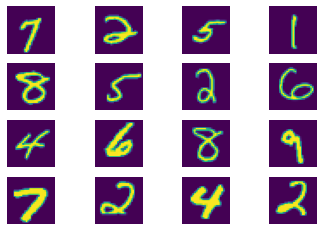

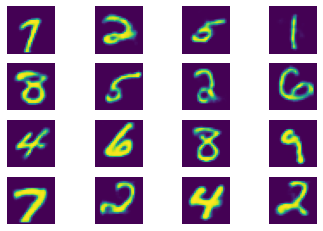

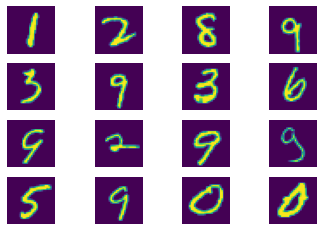

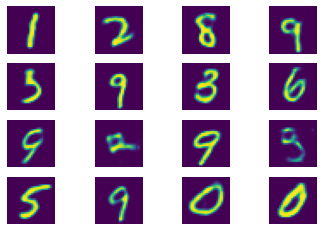

In [ ]:
# Training MNIST latent dimension = 32 
if __name__ == '__main__':
    train_network = Network(latent_dims=32)
    train_network.run('mnist')

VAE Inputs Channel:  784
VAE Latent Dims:  2


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Training Epoch [0]/[15], Loss: 180.8371848063151
Training Epoch [1]/[15], Loss: 163.76342287597657
Training Epoch [2]/[15], Loss: 160.37118069661457
Training Epoch [3]/[15], Loss: 158.34916322428384
Training Epoch [4]/[15], Loss: 156.8249052327474
Training Epoch [5]/[15], Loss: 155.59970703125
Training Epoch [6]/[15], Loss: 154.58921056315103
Training Epoch [7]/[15], Loss: 153.73896009928384
Training Epoch [8]/[15], Loss: 153.05883517252605
Training Epoch [9]/[15], Loss: 152.40990423177084
Training Epoch [10]/[15], Loss: 151.7738736735026
Training Epoch [11]/[15], Loss: 151.29408469238282
Training Epoch [12]/[15], Loss: 150.7935548014323
Training Epoch [13]/[15], Loss: 150.40065630696614
Training Epoch [14]/[15], Loss: 149.96714783528645
Loss: 150.24314692382814


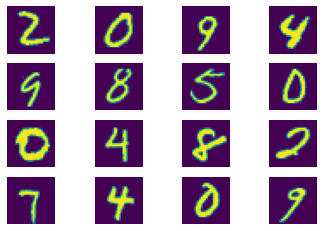

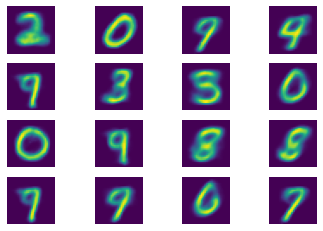

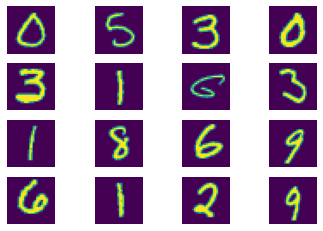

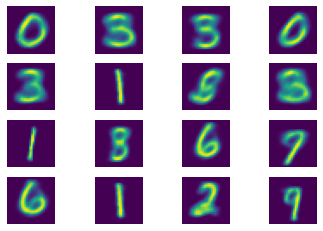

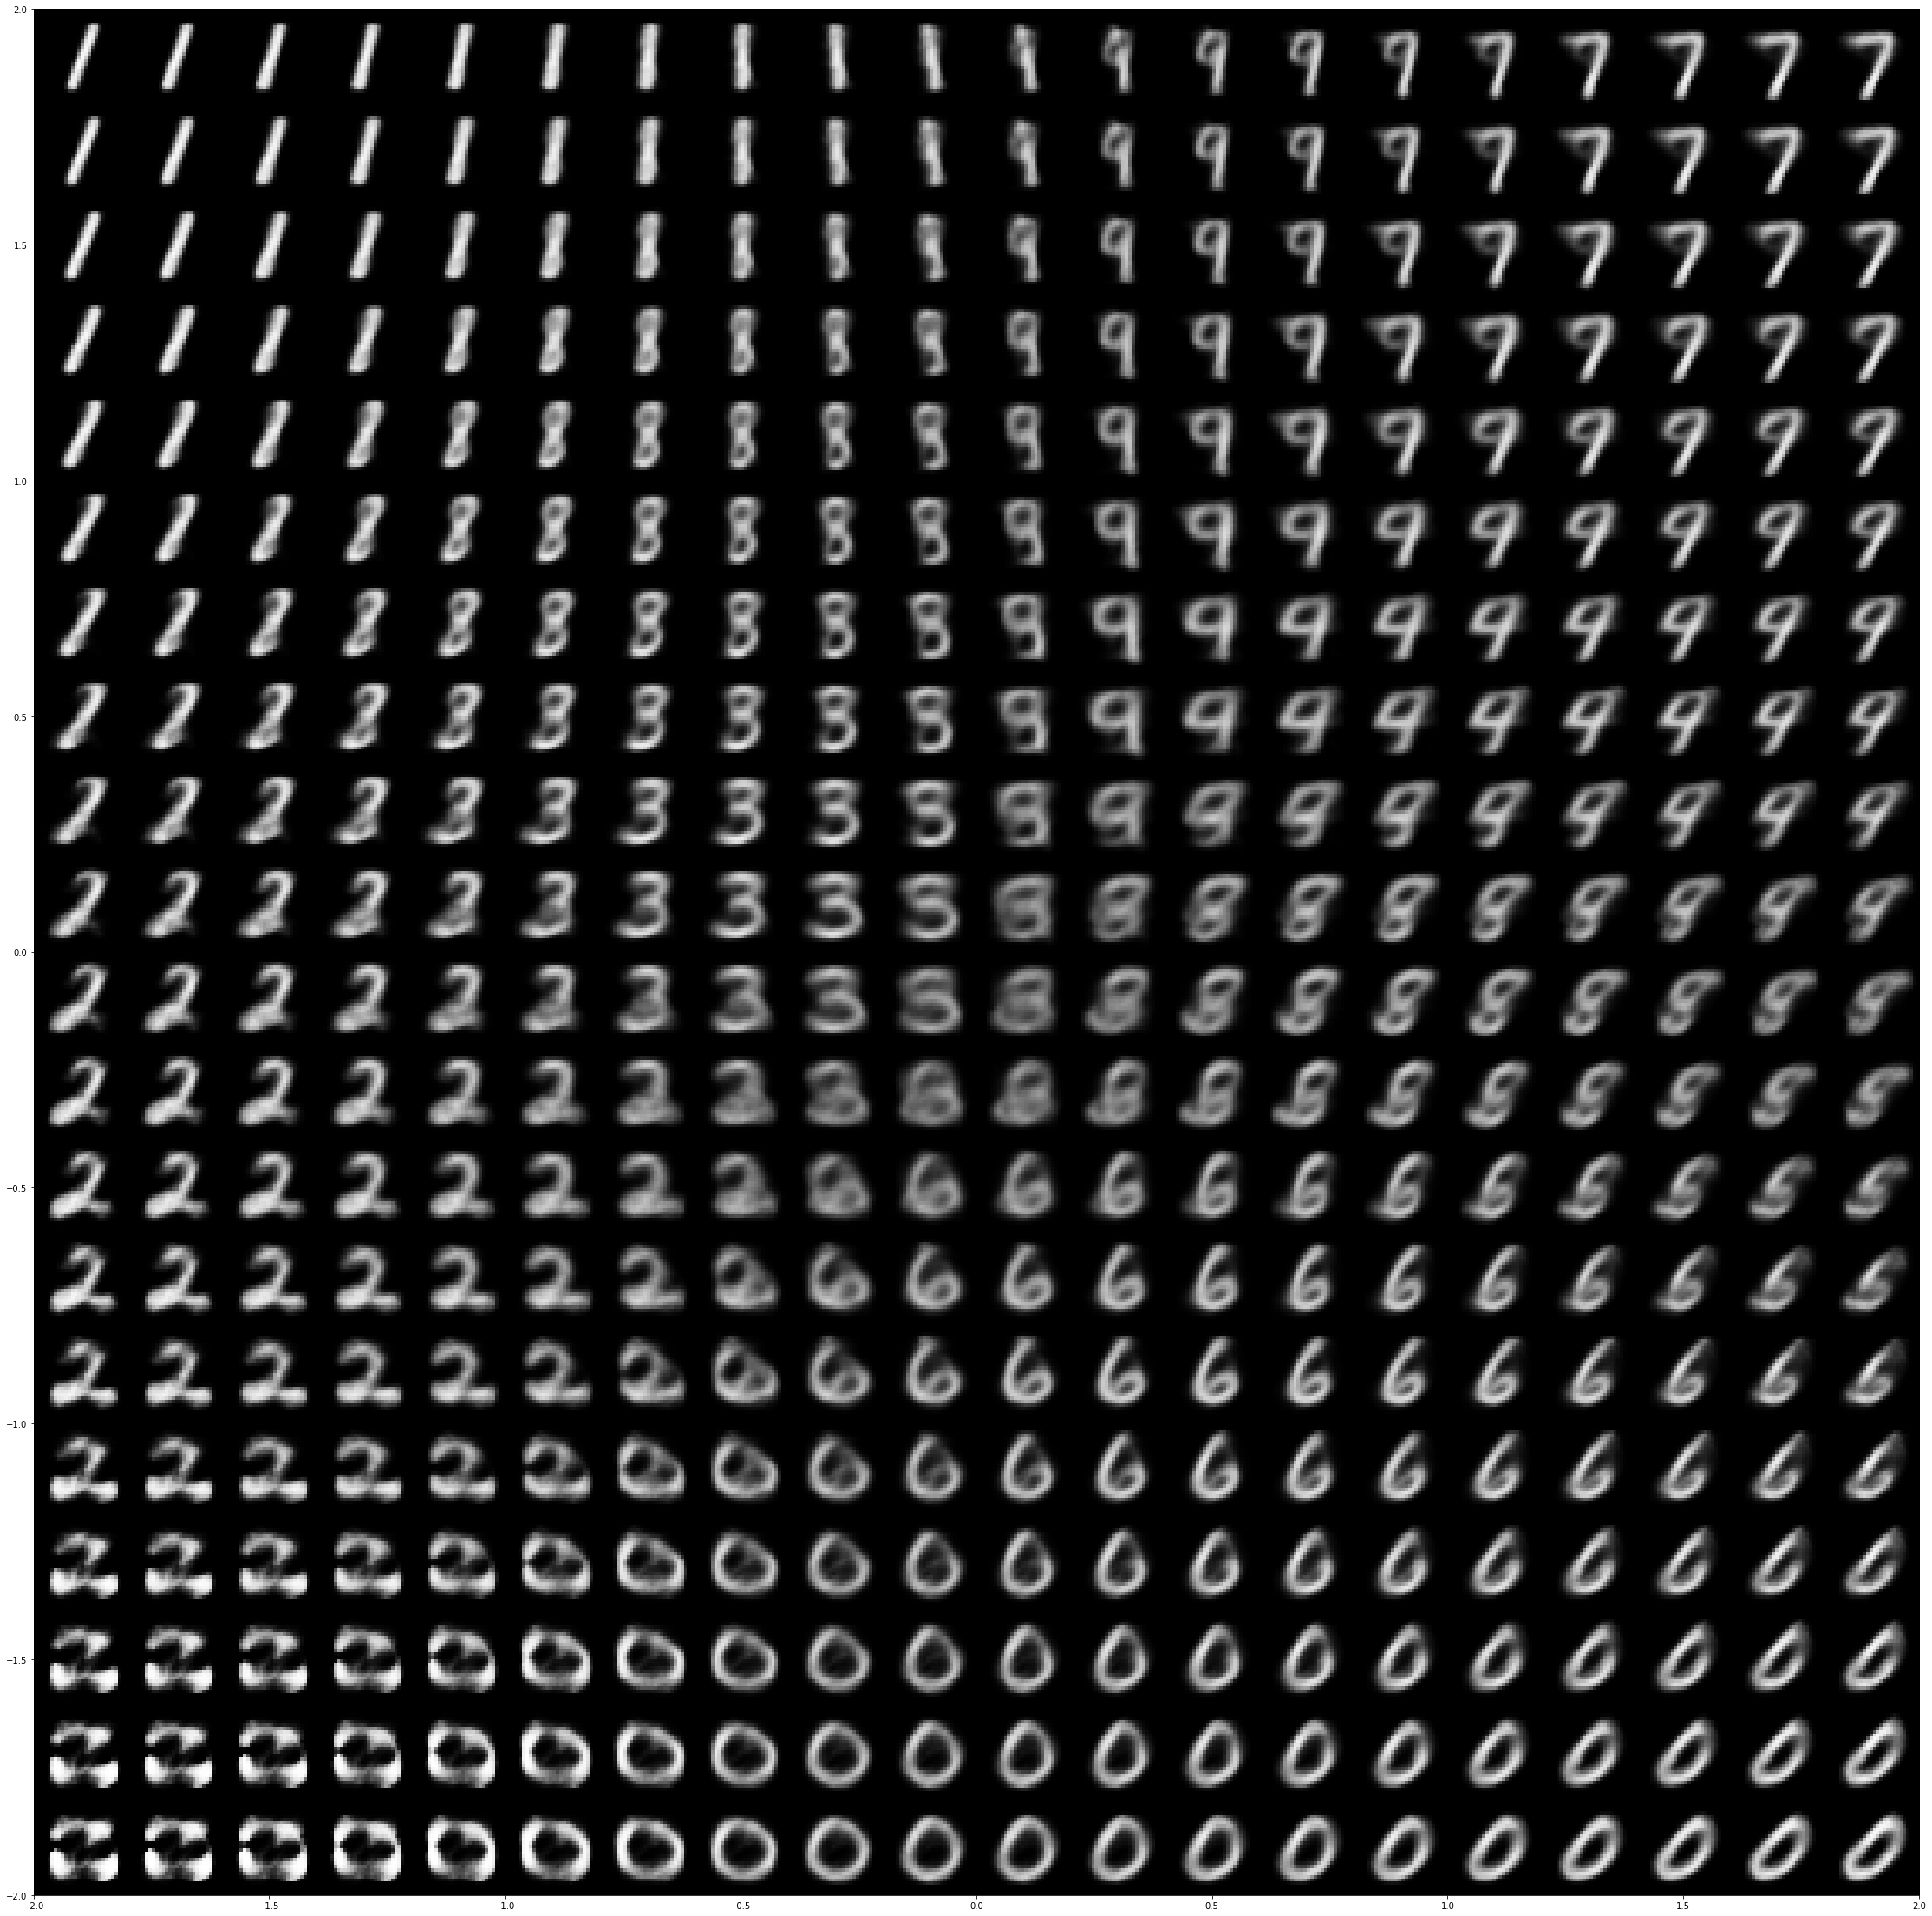

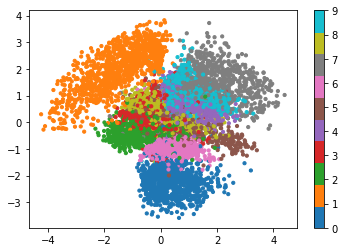

In [ ]:
# Training MNIST latent dimension = 2 
if __name__ == '__main__':
    train_network = Network(latent_dims=2)
    train_network.run('mnist')
    train_network.test_mnist()

VAE Inputs Channel:  784
VAE Latent Dims:  32


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Training Epoch [0]/[15], Loss: 261.354915616862
Training Epoch [1]/[15], Loss: 240.1802667643229
Training Epoch [2]/[15], Loss: 235.733328515625
Training Epoch [3]/[15], Loss: 233.07039674479168
Training Epoch [4]/[15], Loss: 231.3905612141927
Training Epoch [5]/[15], Loss: 230.17612644856771
Training Epoch [6]/[15], Loss: 229.27974770507814
Training Epoch [7]/[15], Loss: 228.62901928710937
Training Epoch [8]/[15], Loss: 228.1157842122396
Training Epoch [9]/[15], Loss: 227.6421278564453
Training Epoch [10]/[15], Loss: 227.3392314860026
Training Epoch [11]/[15], Loss: 227.03582209472657
Training Epoch [12]/[15], Loss: 226.77498446451824
Training Epoch [13]/[15], Loss: 226.56915981445312
Training Epoch [14]/[15], Loss: 226.39719790039064
Loss: 228.19088159179688


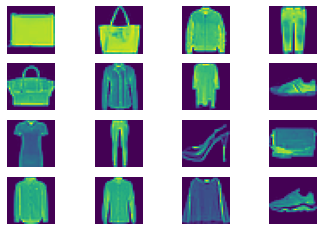

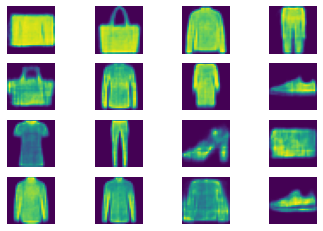

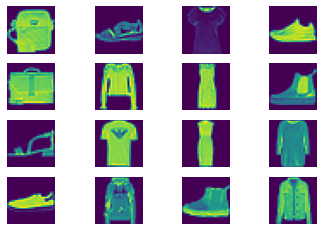

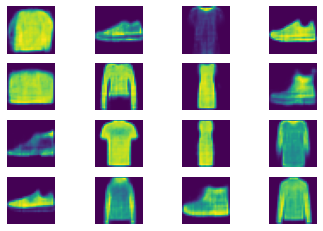

In [ ]:
# Training Fashion MNIST latent dimension = 32 
if __name__ == '__main__':
    train_network = Network(latent_dims=32)
    train_network.run_fashion('fashion_mnist')

VAE Inputs Channel:  784
VAE Latent Dims:  2


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Training Epoch [0]/[15], Loss: 282.43588162434895
Training Epoch [1]/[15], Loss: 268.7322821940104
Training Epoch [2]/[15], Loss: 266.3005124674479
Training Epoch [3]/[15], Loss: 264.73045150553384
Training Epoch [4]/[15], Loss: 263.64095001627607
Training Epoch [5]/[15], Loss: 262.89162350260415
Training Epoch [6]/[15], Loss: 262.194623421224
Training Epoch [7]/[15], Loss: 261.7205713053385
Training Epoch [8]/[15], Loss: 261.2806951904297
Training Epoch [9]/[15], Loss: 261.0110560872396
Training Epoch [10]/[15], Loss: 260.640596468099
Training Epoch [11]/[15], Loss: 260.45228121744793
Training Epoch [12]/[15], Loss: 260.2043429361979
Training Epoch [13]/[15], Loss: 259.93797607421874
Training Epoch [14]/[15], Loss: 259.76670341796876
Loss: 261.3219097167969


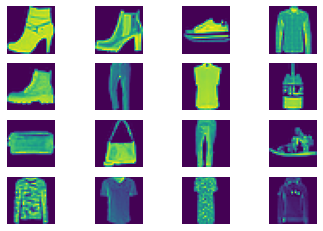

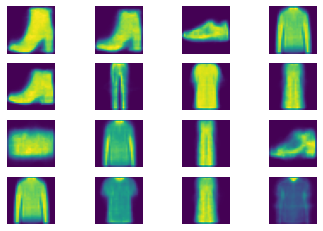

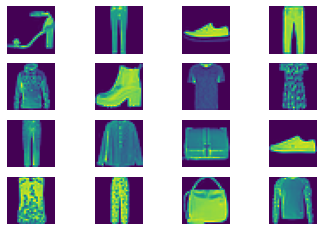

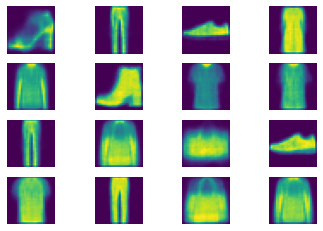

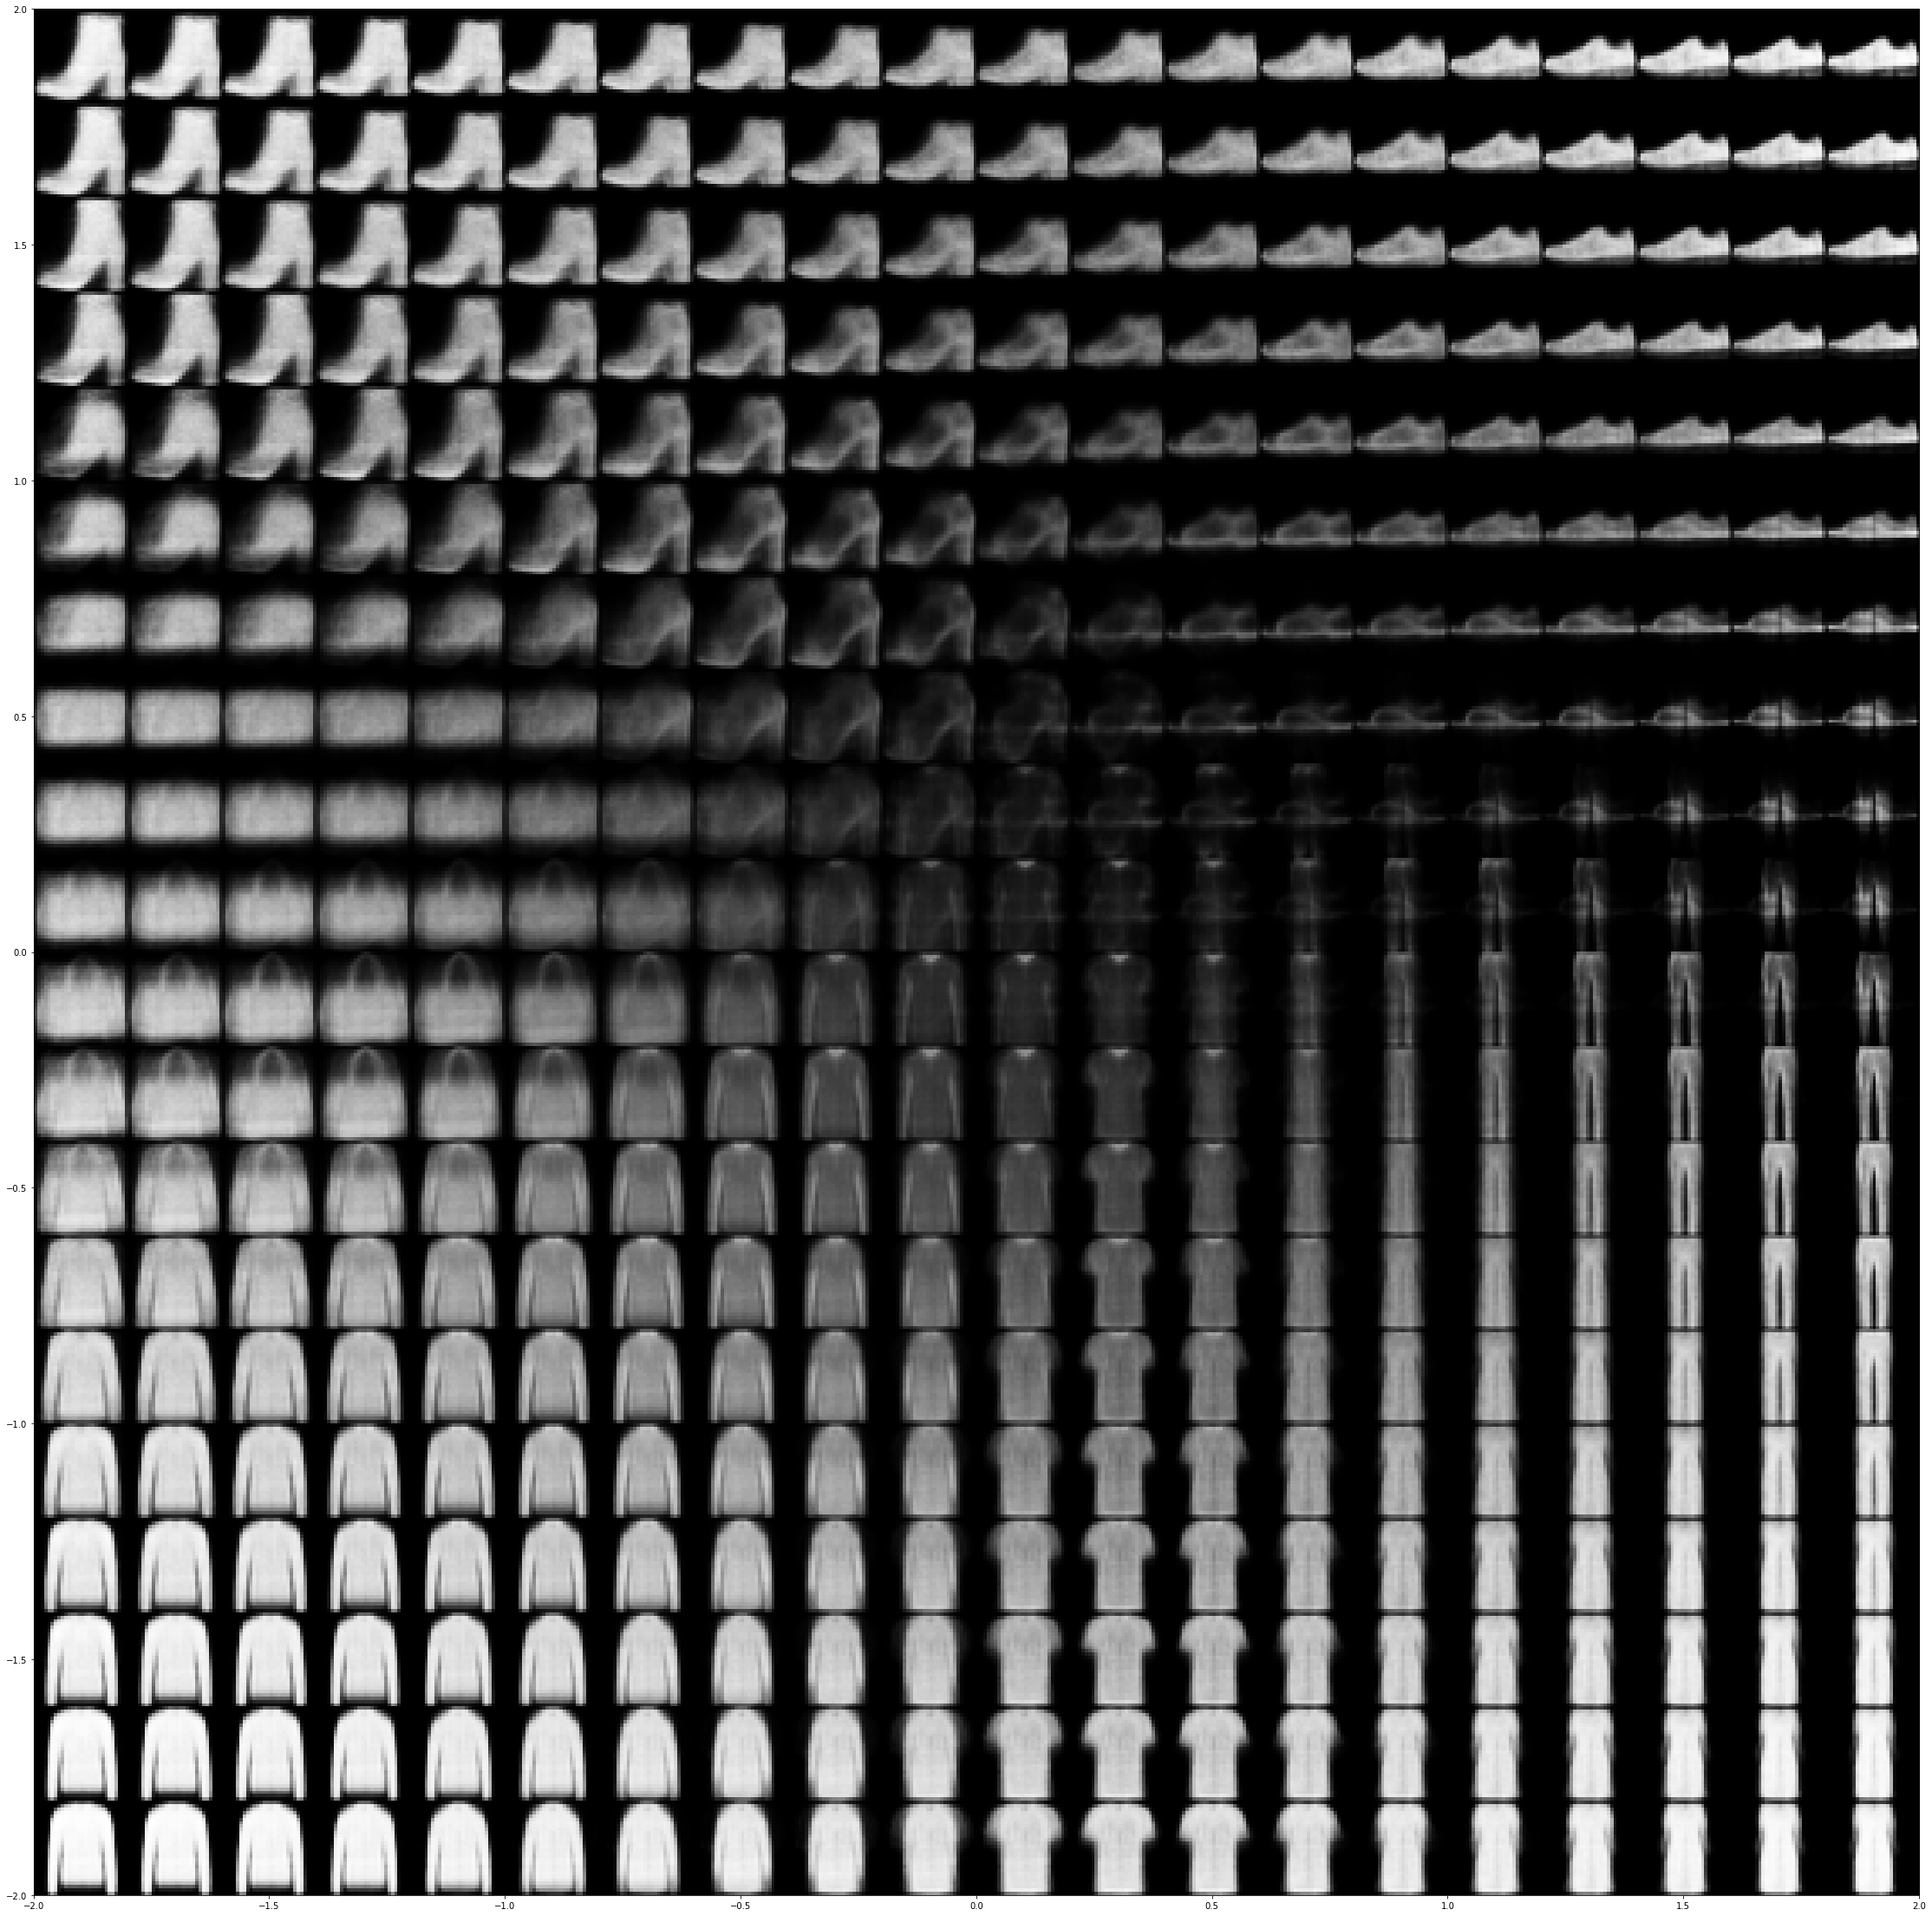

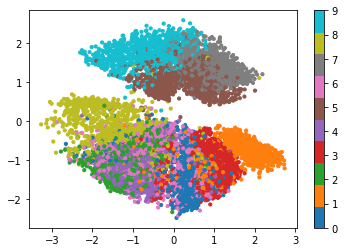

In [ ]:
# Training Fashion MNIST latent dimension = 2 
if __name__ == '__main__':
    train_network = Network(latent_dims=2)
    train_network.run_fashion('fashion_mnist')
    train_network.test_fashion()